In [1]:
!pip install datasets
!pip uninstall -y pyarrow
!pip install --no-cache-dir pyarrow
!pip install numpy==1.26.4
!pip install --upgrade --no-cache-dir datasets pyarrow pandas
!pip install torch torchvision transformers datasets matplotlib seaborn scikit-learn keras pandas

Found existing installation: pyarrow 19.0.1
Uninstalling pyarrow-19.0.1:
  Successfully uninstalled pyarrow-19.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 45.3 MB/s eta 0:00:00a 0:00:01


In [5]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# View sample
print(dataset["train"][2])


{'text': 'im grabbing a minute to post i feel greedy wrong', 'label': 3}


In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
import tensorflow as tf

# Print TensorFlow version
print(tf.__version__)  # Should print the version of TensorFlow installed


2.19.0


                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


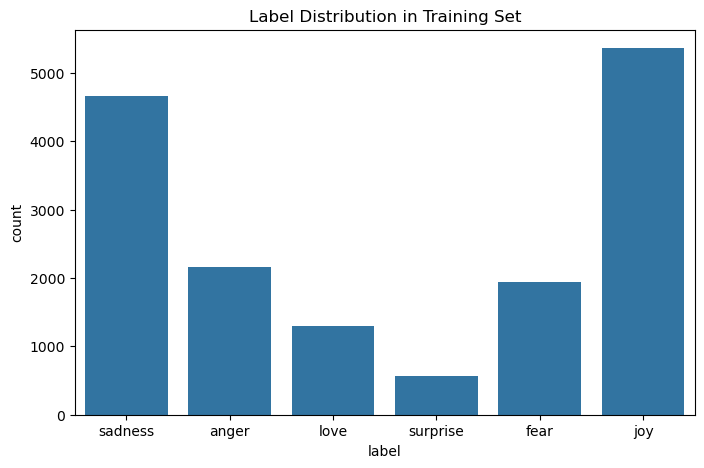

In [7]:
# Extract the dataset
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

# Convert datasets to pandas DataFrames for easier manipulation
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# Display first few rows
print(train_df.head())

# Label mapping
label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# Apply mapping to labels
train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

# Plot label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=train_df['label'])
plt.title("Label Distribution in Training Set")
plt.show()


In [9]:
# Parameters
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_df['text'].values)

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_val = tokenizer.texts_to_sequences(val_df['text'].values)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(test_df['text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare labels
y_train = pd.get_dummies(train_df['label']).values
y_val = pd.get_dummies(val_df['label']).values
y_test = pd.get_dummies(test_df['label']).values

print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Testing shape: {X_test.shape}")


Training shape: (16000, 100)
Validation shape: (2000, 100)
Testing shape: (2000, 100)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))  # 6 classes for emotion classification

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


In [15]:
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,006 (7.94 MB)

 Trainable params: 2,081,006 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
BATCH_SIZE = 32
EPOCHS = 5

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.3981 - loss: 1.4922 - val_accuracy: 0.7910 - val_loss: 0.6139
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.8634 - loss: 0.4251 - val_accuracy: 0.9135 - val_loss: 0.2405
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.9490 - loss: 0.1555 - val_accuracy: 0.9240 - val_loss: 0.2097
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.9652 - loss: 0.1052 - val_accuracy: 0.9210 - val_loss: 0.2248
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.9736 - loss: 0.0769 - val_accuracy: 0.9240 - val_loss: 0.1975


In [19]:
# Evaluate the model on the test set
score, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=list(label_mapping.values())))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9205 - loss: 0.2038
Test Accuracy: 0.9215
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

     sadness       0.91      0.93      0.92       275
         joy       0.88      0.92      0.90       224
        love       0.94      0.94      0.94       695
       anger       0.80      0.84      0.82       159
        fear       0.97      0.94      0.96       581
    surprise       0.77      0.74      0.75        66

    accuracy                           0.92      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.92      0.92      0.92      2000



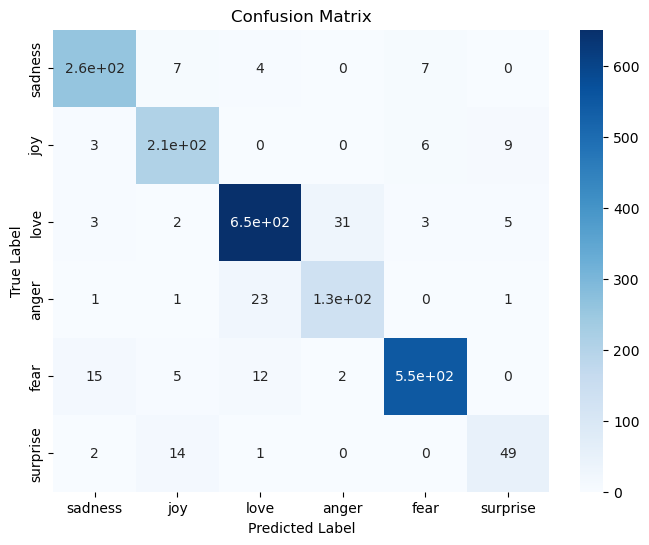

In [21]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


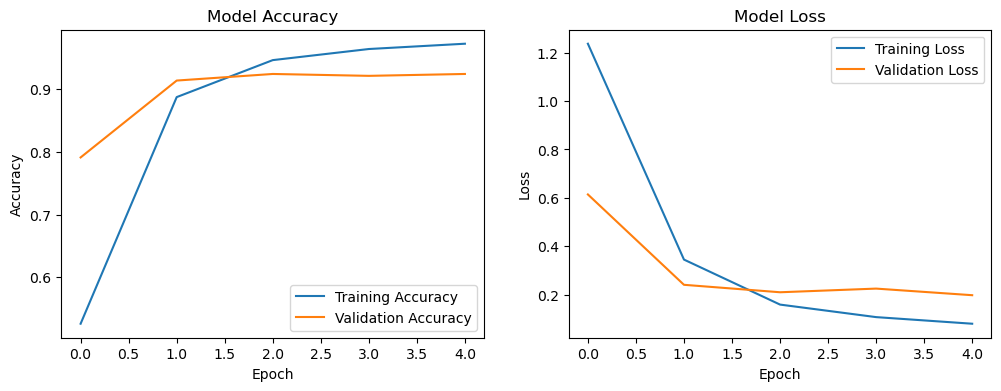

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


This Section Created for Team Member 4 Task

In [ ]:
print(f"Length of y_pred: {len(y_pred)}")

In [39]:
# Save to a CSV file
np.savetxt("predicted_labels.csv", y_pred, delimiter=",", fmt='%d')
print("Predictions saved to predicted_labels.csv")

Predictions saved to predicted_labels.csv


In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)  # Print entire array
print("Predicted labels (NumPy array):")
print(y_pred)

In [25]:
# Assuming y_true is already defined as follows:
# y_true = np.argmax(y_test, axis=1)

# Map numeric labels to their corresponding text labels using label_mapping
label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
y_true_text = [label_mapping[label] for label in y_true]

# Print all y_true as text
print("\n".join(y_true_text))


fear
fear
fear
love
fear
joy
sadness
love
love
sadness
joy
fear
joy
love
anger
fear
love
fear
sadness
love
fear
love
love
fear
fear
joy
sadness
fear
joy
sadness
joy
sadness
fear
sadness
fear
love
love
fear
love
love
sadness
fear
love
fear
love
sadness
love
love
joy
joy
fear
joy
love
fear
love
fear
fear
love
fear
sadness
fear
fear
love
love
fear
surprise
fear
sadness
joy
surprise
love
anger
surprise
love
anger
sadness
love
fear
love
anger
love
sadness
fear
love
fear
fear
love
love
love
fear
love
joy
sadness
joy
sadness
sadness
anger
fear
sadness
fear
fear
fear
fear
joy
sadness
sadness
love
love
joy
fear
love
anger
joy
love
fear
love
love
joy
fear
love
fear
love
fear
sadness
fear
anger
fear
joy
fear
fear
love
anger
fear
sadness
sadness
love
joy
sadness
fear
love
love
fear
joy
love
love
fear
love
joy
joy
anger
fear
anger
surprise
fear
love
fear
love
love
sadness
fear
sadness
sadness
love
joy
joy
love
anger
anger
anger
fear
anger
sadness
love
love
fear
sadness
love
love
fear
fear
joy
love


In [27]:
# Assuming y_true is already defined as follows:
# y_true = np.argmax(y_test, axis=1)

# Map numeric labels to their corresponding text labels using label_mapping
label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
y_true_text = [label_mapping[label] for label in y_true]

# Save the labels to a plain text file
with open("y_true_labels.txt", "w") as file:
    for label in y_true_text:
        file.write(label + "\n")

print("Labels saved to y_true_labels.txt")


Labels saved to y_true_labels.txt
